**Diffusion equation with training points resampling**

Retyped by Theodoret Putra Agatho on 5 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.resample.html)

In [1]:
pip install deepxde

**Problem setup**

We will solve a diffusion equation:

\begin{align}
        \frac{\partial y}{\partial t} = \frac{\partial ^2 y}{\partial x^2} - e^{-t} (sin(\pi x) - \pi ^2 sin((\pi x)), x \in [-1,1], t \in [0,1]
    \end{align}

with the initial condition

\begin{align}
        y(x, 0) = sin(\pi x).
    \end{align}

and the Dirichlet boundary condition

\begin{align}
        y(-1,t) = y(1,t) = 0.
    \end{align}

The reference solution is $y = e^{-t}sin(\pi x)$.

**Implementation**

This description goes through the implementation of a solver for the above described diffusion equation step-by-step.

First, the DeepXDE, NumPy (`np`), and TensorFlow (`tf`) modules are imported:

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We begin by defining computational geometries. We can use a built-in-class `interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the diffusion equation:

In [4]:
def pde(x, y):
  dy_t = dde.grad.jacobian(y, x, j=1)
  dy_xx = dde.grad.hessian(y, x, j=0)
  return (
      dy_t
      - dy_xx
      + tf.exp(-x[:, 1:])
      * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
  )

The first argument to `pde` is 2-dimenasional vector where the first component(`x[:,0:1]`) is $x$-coordinate and the second component(`x[:,1:]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $y(x, t)$.

Next, we consider the boundary/initial condition. First, the reference solution `func` is defined as:

In [5]:
def func(x):
  return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

`on_boundary` is chosen here to use the whole boundary of the computational domain as the boundary condition. We include the `geotime` space, time geommetry created above and `on_boundary` as the BC in the `DirichletBC` function of DeepXDE. We also define `IC` which is the initial conditon for the diffusion equation and we use the computational domain, initial function, and `on_initial` to specify the IC.

In [6]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

Now, we have specified the geometry, the PDE residual and the boundary/initial conditions. We then define `TimePDE` problem as

In [7]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    train_distribution="pseudo",
    solution=func,
    num_test=10000,
)

The number 40 is the number of training residual points sampled inside the domain, and the number 20 is the number of training points sampled on the boundary (the left and right endpoints of the interval). We also include 10 initial residual points for the initial conditions and 10000 points for testing the PDE residual. The argument `train_distribution='pseudo` means that the sample training points follows a pseudo-random distribution.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers and width 32:

In [8]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

The folllowing code is to apply mini-batch gradient descent sampling method. The period is the period of resampling. Here, the training points in the domain will be resampled every 100 iterations.

In [10]:
resampler = dde.callbacks.PDEPointResampler(period=100)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate. We then train the model for 2000 iterations.

In [11]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=2000, callbacks=[resampler])

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.287618 s

'compile' took 2.047339 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.37e+01, 3.10e-02, 4.06e-01]    [1.70e+01, 3.10e-02, 4.06e-01]    [1.09e+00]    
1000      [4.65e-03, 6.28e-03, 7.03e-04]    [1.81e-02, 6.28e-03, 7.03e-04]    [1.08e-01]    
2000      [4.61e-04, 4.49e-04, 2.07e-04]    [2.59e-03, 4.49e-04, 2.07e-04]    [2.75e-02]    

Best model at step 2000:
  train loss: 1.12e-03
  test loss: 3.24e-03
  test metric: [2.75e-02]

'train' took 5.818302 s



We also save and plot the best trained result and loss history.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


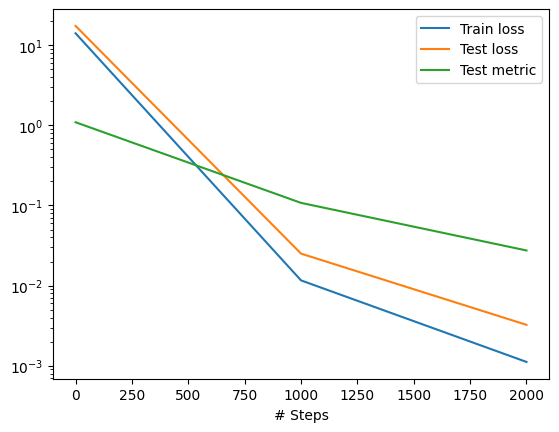

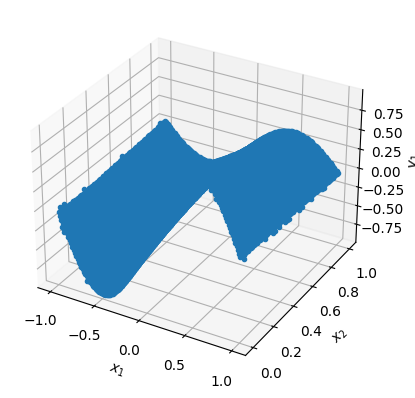

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)